### Import necessary packages

In [220]:
pip install ruptures

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numpy in c:\users\anany\anaconda3\lib\site-packages (from ruptures) (1.20.1)



In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn
import matplotlib.dates as mdates
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import ruptures as rpt

### Assumptions made for the analysis:
1. confirmed cases = total infection
2. mask mandates null does not mean there is no making policy in place.   We impute it as unknown
       
Population :
    April 20 : 4,731,145
    July 21 :  4,728,030

## Reading data from the given files

In [203]:
conf_cases = pd.read_csv("RAW_us_confirmed_cases.csv")
mask_use_by_county = pd.read_csv("mask-use-by-county.csv")
mm = pd.read_csv("U.S._State_and_Territorial_Public_Mask_Mandates_From_April_10__2020_through_August_15__2021_by_County_by_Day.csv")

In [204]:
conf_cases.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22
0,Alabama,Autauga,84001001,US,USA,840,1001.0,US,32.539527,-86.644082,...,18480,18480,18480,18480,18480,18511,18511,18511,18511,18511
1,Alabama,Baldwin,84001003,US,USA,840,1003.0,US,30.727750,-87.722071,...,65895,65895,65895,65895,65895,65973,65973,65973,65973,65973
2,Alabama,Barbour,84001005,US,USA,840,1005.0,US,31.868263,-85.387129,...,6926,6926,6926,6926,6926,6930,6930,6930,6930,6930
3,Alabama,Bibb,84001007,US,USA,840,1007.0,US,32.996421,-87.125115,...,7560,7560,7560,7560,7560,7575,7575,7575,7575,7575
4,Alabama,Blount,84001009,US,USA,840,1009.0,US,33.982109,-86.567906,...,17286,17286,17286,17286,17286,17320,17320,17320,17320,17320


#Not needed anymore
conf_cases.columns = conf_cases.iloc[0]
conf_cases = conf_cases.iloc[1:,0:]
conf_cases.head()

#### Filter out for the required county : Harris County in Texas

In [205]:
Harris = conf_cases[(conf_cases["Province_State"] == "Texas") & (conf_cases["Admin2"] == "Harris")]
Harris.head()

,Province_State,Admin2,UID,iso2,iso3,code3,FIPS,Country_Region,Lat,Long_,...,10/22/22,10/23/22,10/24/22,10/25/22,10/26/22,10/27/22,10/28/22,10/29/22,10/30/22,10/31/22
2800,Texas,Harris,84048201,US,USA,840,48201.0,US,29.858649,-95.393395,...,1219126,1219126,1219564,1219564,1219873,1219873,1220195,1220195,1220195,1220616


## Data pre processing

Data needs to be cleaned and standardized 

In [206]:
#The first few columns are general info about the state
Harris_info = conf_cases[conf_cases.columns[0:11]]
# FIPS needed to extraxt info from mask_use_by_county
Harris_FIPS = conf_cases["FIPS"].values[0]

In [207]:
Harris_FIPS

1001.0

In [208]:
mask_use_by_county.head()

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444
1,1003,0.083,0.059,0.098,0.323,0.436
2,1005,0.067,0.121,0.120,0.201,0.491
3,1007,0.020,0.034,0.096,0.278,0.572
4,1009,0.053,0.114,0.180,0.194,0.459


In [209]:
Harris_mask_use

,COUNTYFP,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS
0,1001,0.053,0.074,0.134,0.295,0.444


In [210]:
Harris_mask_use = mask_use_by_county[mask_use_by_county["COUNTYFP"] == Harris_FIPS]
mm.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
0,AL,Autauga County,1,1,4/10/2020,2,NaN,NaN,NaN,NaN
1,AL,Autauga County,1,1,4/11/2020,2,NaN,NaN,NaN,NaN
2,AL,Autauga County,1,1,4/12/2020,2,NaN,NaN,NaN,NaN
3,AL,Autauga County,1,1,4/13/2020,2,NaN,NaN,NaN,NaN
4,AL,Autauga County,1,1,4/14/2020,2,NaN,NaN,NaN,NaN


In [60]:
#mask_mandates_april_2020_aug_2021["State_Tribe_Territory"].value_counts()
mm["County_Name"].value_counts()


Washington County    14790
Jefferson County     12325
Franklin County      11832
Lincoln County       11339
Jackson County       11339
                     ...  
Norfolk County         493
Nantucket County       493
Hampden County         493
Dukes County           493
St. John Island        493
Name: County_Name, Length: 1968, dtype: int64

In [211]:
Harris_mask_mandates = mm[(mm["State_Tribe_Territory"] == "TX") & (mm['County_Name'] == 'Harris County')]
Harris_mask_mandates.head()

,State_Tribe_Territory,County_Name,FIPS_State,FIPS_County,date,order_code,Face_Masks_Required_in_Public,Source_of_Action,URL,Citation
697718,TX,Harris County,48,201,4/10/2020,2,NaN,NaN,NaN,NaN
697719,TX,Harris County,48,201,4/11/2020,2,NaN,NaN,NaN,NaN
697720,TX,Harris County,48,201,4/12/2020,2,NaN,NaN,NaN,NaN
697721,TX,Harris County,48,201,4/13/2020,2,NaN,NaN,NaN,NaN
697722,TX,Harris County,48,201,4/14/2020,2,NaN,NaN,NaN,NaN


In [212]:
Harris_mask_mandates["Face_Masks_Required_in_Public"].fillna("Unknown",inplace=True)
Harris_mask_mandates["Face_Masks_Required_in_Public"].value_counts()

<ipython-input-212-2b8ae90a8761>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Harris_mask_mandates["Face_Masks_Required_in_Public"].fillna("Unknown",inplace=True)


Yes        250
No         159
Unknown     84
Name: Face_Masks_Required_in_Public, dtype: int64

In [213]:
#To analyse the number of cases
Harris_cases = Harris.iloc[:,12:].transpose().reset_index()

In [214]:
Harris_cases.columns=['Date', 'Number_of_cases']

In [215]:
Harris_cases.head()

,Date,Number_of_cases
0,1/23/20,0
1,1/24/20,0
2,1/25/20,0
3,1/26/20,0
4,1/27/20,0


#### Convert Date to DateTime and sort ascending

In [216]:
Harris_cases["Date"] = pd.to_datetime(Harris_cases["Date"], format="%m/%d/%y")
#Harris_cases["Date"] = Harris_cases["Date"].astype()
Harris_cases = Harris_cases.sort_values(by='Date')

In [217]:
Harris_cases["Date"].value_counts()

2020-01-23    1
2021-12-04    1
2021-11-21    1
2021-11-22    1
2021-11-23    1
             ..
2020-12-30    1
2020-12-31    1
2021-01-01    1
2021-01-02    1
2022-10-31    1
Name: Date, Length: 1013, dtype: int64

In [218]:
Harris_cases.head()

,Date,Number_of_cases
0,2020-01-23,0
1,2020-01-24,0
2,2020-01-25,0
3,2020-01-26,0
4,2020-01-27,0


### Merge mask mandates to case data

In [219]:
mm_subset = Harris_mask_mandates[['date' , 'Face_Masks_Required_in_Public']]
mm_subset["Date"] = pd.to_datetime(mm_subset["date"], format="%m/%d/%Y")
mm_subset.drop( columns= "date" , inplace = True)
mm_subset.head()


<ipython-input-219-54cffccc56d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mm_subset["Date"] = pd.to_datetime(mm_subset["date"], format="%m/%d/%Y")
<ipython-input-219-54cffccc56d5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mm_subset.drop( columns= "date" , inplace = True)


,Face_Masks_Required_in_Public,Date
697718,Unknown,2020-04-10
697719,Unknown,2020-04-11
697720,Unknown,2020-04-12
697721,Unknown,2020-04-13
697722,Unknown,2020-04-14


In [229]:
df = Harris_cases.merge(mm_subset, on='Date', how='left')

## Visual inspection : the number of covid cases over time

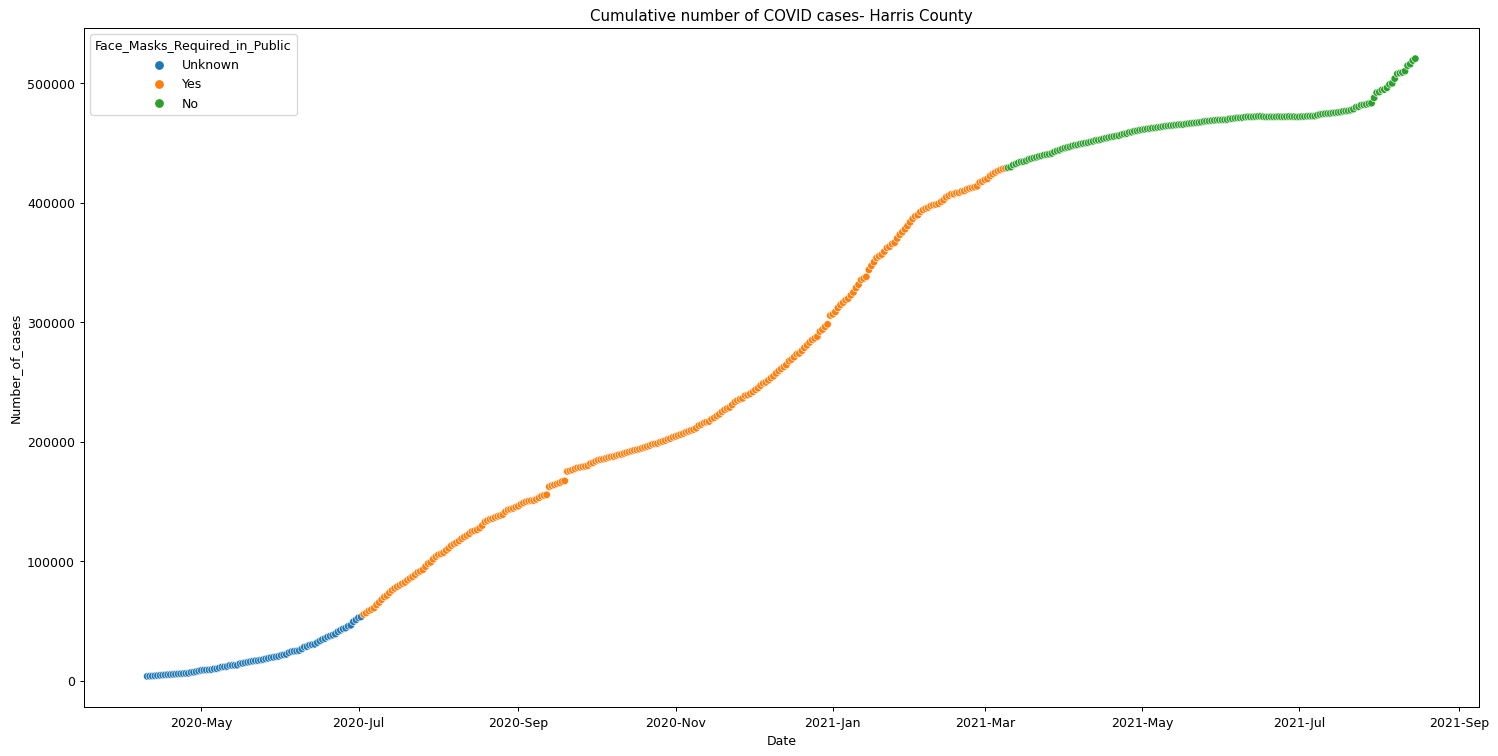

In [407]:
figure(figsize=(20, 10), dpi=90)

sns.scatterplot(x = "Date", y = "Number_of_cases", data = df, hue='Face_Masks_Required_in_Public'   )

dtFmt = mdates.DateFormatter('%Y-%b')
plt.gca().xaxis.set_major_formatter(dtFmt) 

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.title('Cumulative number of COVID cases- Harris County')
plt.savefig('Cumulative number of COVID cases- Harris County.jpeg')
plt.show()

We see that in the beginning of 2020 there was no masking mandate, and the cases saw a steady rise. Then masking mandates were introduced across the globe, and the spread of covid was controlled. To see that better, we see the daily number of cases below. 

Calculate the number of daily cases from cumulative cases by subtracting the number of cases on the previous day.

In [231]:
df['Number_of_daily_cases'] = df['Number_of_cases'] - df.shift(1)['Number_of_cases']
df['Population'] = 4728030
df['Infection_rate'] = df['Number_of_daily_cases']/df['Population']
df.head()

,Date,Number_of_cases,Face_Masks_Required_in_Public,Number_of_daily_cases,Population,Infection_rate
0,2020-01-23,0,NaN,NaN,4728030,NaN
1,2020-01-24,0,NaN,0.0,4728030,0.0
2,2020-01-25,0,NaN,0.0,4728030,0.0
3,2020-01-26,0,NaN,0.0,4728030,0.0
4,2020-01-27,0,NaN,0.0,4728030,0.0


In [223]:
# Checking for nulls
df['Number_of_daily_cases'].isnull().sum()

1

In [224]:
df["Face_Masks_Required_in_Public"].value_counts()

Yes        250
No         159
Unknown     84
Name: Face_Masks_Required_in_Public, dtype: int64

In [225]:
df = df.fillna(0)

## The number of new confirmed cases per day

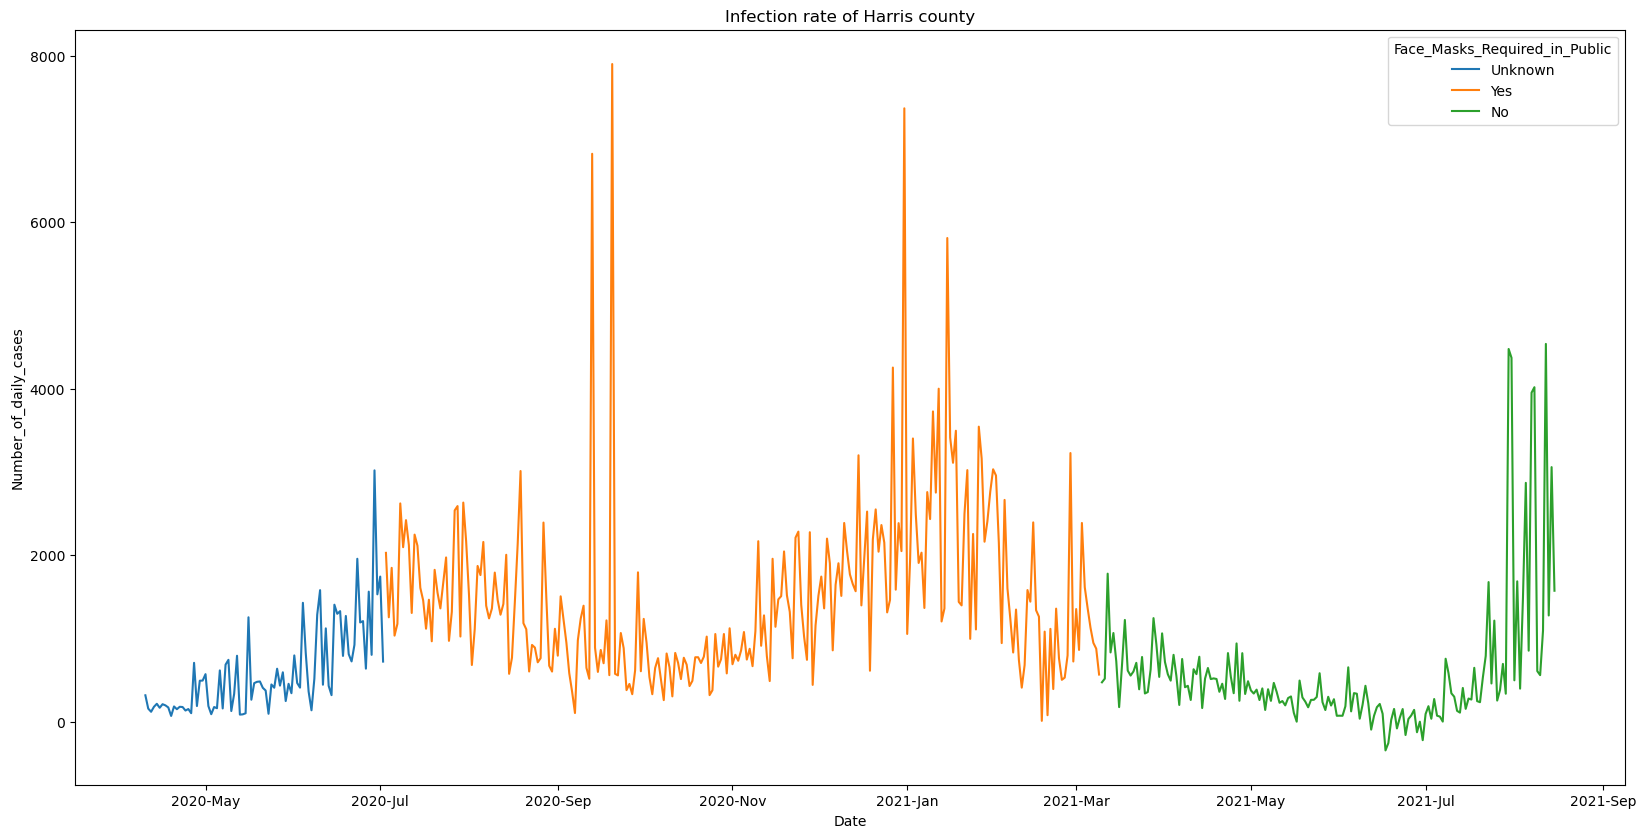

In [408]:
figure(figsize=(20, 10), dpi=100)
sns.lineplot(x = "Date", y = "Number_of_daily_cases", data=df, hue='Face_Masks_Required_in_Public')
# Major ticks every half year, minor ticks every month,

dtFmt = mdates.DateFormatter('%Y-%b')
plt.gca().xaxis.set_major_formatter(dtFmt) 

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.title('Infection rate of Harris county')
plt.savefig('Infection rate of Harris county.jpeg')

plt.show()

We see that when the masking mandate was introduced there was a dip in the number of COVID cases, but then the cases started rising again. This decrease can also be attributed to vaccinations in addition to the masking policies.

## How the mask mandate changed

Thank you Charles for this code snippet.

There is a delay between the time of infection and the time a case is confirmed. Many factors may contribute to such delay. People may not show symptoms right away after infection. It may take a few days for the testing results to become available especially during the early period of the pandemic. To visualize the delay, we first see how the masking mandates changes over time.


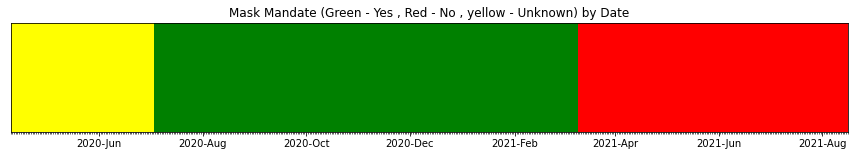

In [227]:
# See the making mandate change points visually
temp = df[['Date', 'Face_Masks_Required_in_Public']]

fig, ax= plt.subplots(figsize=(15,2))

# plot green for event==1
s1 = temp[temp['Face_Masks_Required_in_Public'] == 'Yes']
inxval = matplotlib.dates.date2num(pd.to_datetime(s1.Date))
times= list(zip(inxval, np.ones(len(s1))))
plt.broken_barh(times, (-1,1), color="green")
# plot red for event==0
s2 = temp[temp['Face_Masks_Required_in_Public'] == 'No']
inxval = matplotlib.dates.date2num(pd.to_datetime(s2.Date))
times= list(zip(inxval, np.ones(len(s2))))
plt.broken_barh(times, (-1,1), color="red")

# plot yellow for unknown
s3 = temp[temp['Face_Masks_Required_in_Public'] == 'Unknown']
inxval = matplotlib.dates.date2num(pd.to_datetime(s3.Date))
times= list(zip(inxval, np.ones(len(s3))))
plt.broken_barh(times, (-1,1), color="yellow")

#format axes
ax.margins(0)
ax.set_yticks([])
ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
ax.xaxis.set_minor_locator(matplotlib.dates.DayLocator())


dtFmt = mdates.DateFormatter('%Y-%b')
plt.gca().xaxis.set_major_formatter(dtFmt) 

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.title('Mask Mandate (Green - Yes , Red - No , yellow - Unknown) by Date')
plt.show()

In [119]:
### Check for other important fields

In [120]:
mm['Source_of_Action'].value_counts()

Official         986061
Press release      1494
Name: Source_of_Action, dtype: int64

In [122]:
mm['Face_Masks_Required_in_Public'].value_counts()

Yes    734112
No     253443
Name: Face_Masks_Required_in_Public, dtype: int64

The research question is about how a time series changes. The infection time series is a set of slopes. Therefore the question is about a derivative function. We want to check the change in slope over time

## Infection rate

Infection rate is calculated as the number of new cases per day by the population of the county.

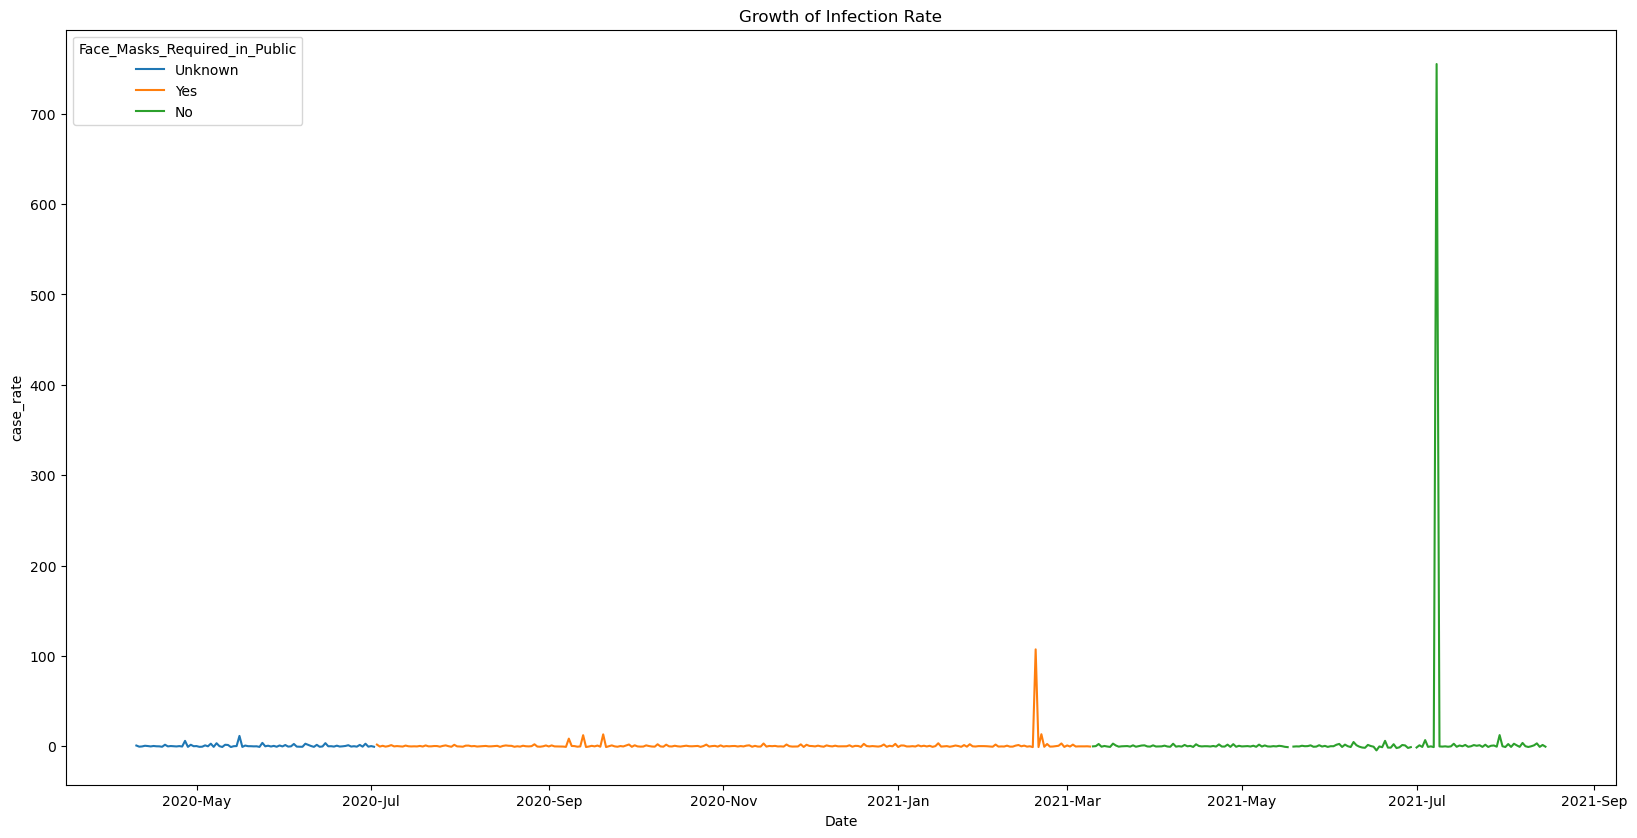

In [410]:
date_arr=np.array(df['Date'])
case_arr=np.array(df['Number_of_daily_cases']).astype('int')


df['case_rate']=np.diff(case_arr,prepend=case_arr[-1])/df.shift(1)['Number_of_daily_cases']

figure(figsize=(20, 10), dpi=100)
sns.lineplot(x = "Date", y = "case_rate", data=df, hue='Face_Masks_Required_in_Public')
# Major ticks every half year, minor ticks every month,

dtFmt = mdates.DateFormatter('%Y-%b')
plt.gca().xaxis.set_major_formatter(dtFmt) 

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.title('Growth of Infection Rate')


plt.savefig('Growth of Infection Rate.jpeg')
plt.show()

### Check the second order central difference

Thank you Tharun for this approach idea. 

We now see the second order difference in the number of cases.

In [411]:
df["case_rate_2"] = pd.Series(np.gradient(df["Number_of_daily_cases"]), df["Date"], name='case_rate_2').values

In [412]:
df["case_rate_2"].describe()

count    1011.000000
mean        0.624629
std       693.276706
min     -4101.000000
25%      -181.500000
50%         0.000000
75%       152.000000
max      4875.500000
Name: case_rate_2, dtype: float64

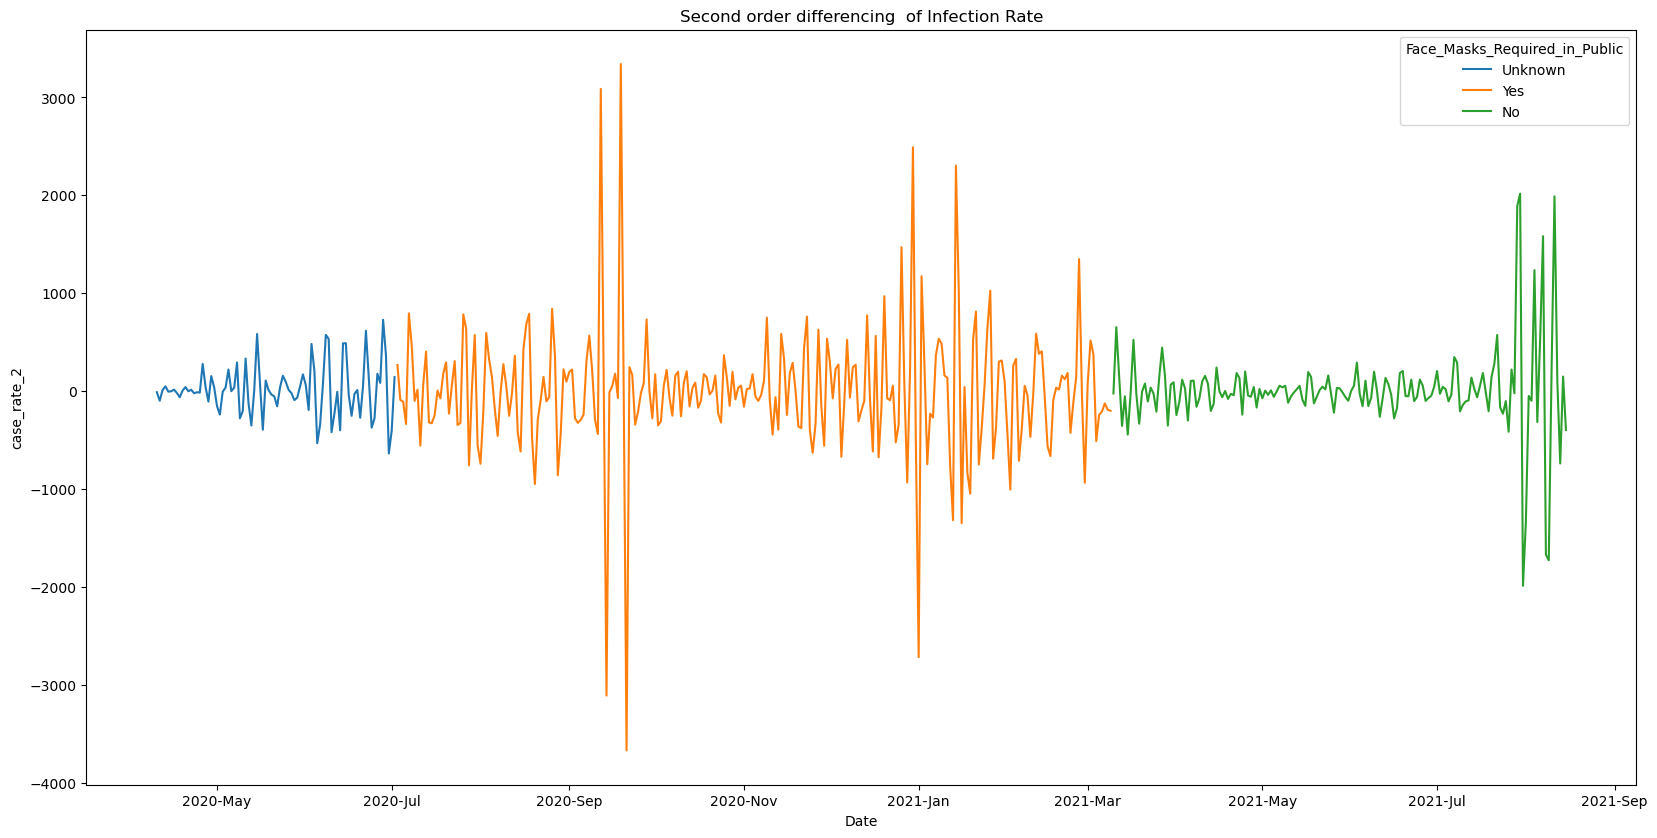

In [414]:
figure(figsize=(20, 10), dpi=100)

sns.lineplot(x = "Date", y = "case_rate_2", data=df,  hue='Face_Masks_Required_in_Public')

dtFmt = mdates.DateFormatter('%Y-%b')
plt.gca().xaxis.set_major_formatter(dtFmt) 

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

plt.title('Second order differencing  of Infection Rate')

plt.savefig('Second order differencing  of Infection Rate.jpeg')
plt.show()

In [263]:
df.Date.max()

Timestamp('2022-10-31 00:00:00')

In [264]:
df.Date.min()

Timestamp('2020-01-23 00:00:00')

In [265]:
df.head()

,Date,Number_of_cases,Face_Masks_Required_in_Public,Number_of_daily_cases,Population,Infection_rate,case_rate,case_rate_2
0,2020-01-23,0,NaN,NaN,4728030,NaN,NaN,NaN
1,2020-01-24,0,NaN,0.0,4728030,0.0,NaN,NaN
2,2020-01-25,0,NaN,0.0,4728030,0.0,NaN,0.0
3,2020-01-26,0,NaN,0.0,4728030,0.0,NaN,0.0
4,2020-01-27,0,NaN,0.0,4728030,0.0,NaN,0.0


In [364]:
df2=df[df['Date']<'2021-9-10']

In [365]:
df2.head()

,Date,Number_of_cases,Face_Masks_Required_in_Public,Number_of_daily_cases,Population,Infection_rate,case_rate,case_rate_2
0,2020-01-23,0,NaN,NaN,4728030,NaN,NaN,NaN
1,2020-01-24,0,NaN,0.0,4728030,0.0,NaN,NaN
2,2020-01-25,0,NaN,0.0,4728030,0.0,NaN,0.0
3,2020-01-26,0,NaN,0.0,4728030,0.0,NaN,0.0
4,2020-01-27,0,NaN,0.0,4728030,0.0,NaN,0.0


## Change point detection

In [305]:
import ruptures as rpt

In [426]:
algo2 = rpt.Pelt(model="rbf").fit(np.array(df2['Number_of_cases']).astype('int'))
change_location2 = algo2.predict(pen=5)


In [427]:
#np.array(df2['Number_of_daily_cases']).astype('int')

In [428]:
# Point the change points:
def plot_change_points(ts,ts_change_loc):
    plt.figure(figsize=(16,4))
    sns.lineplot(data=ts, x="Date", y="Number_of_daily_cases", hue='Face_Masks_Required_in_Public')
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.title('Change in the number of COVID cases daily')
    
    dtFmt = mdates.DateFormatter('%Y-%b')
    plt.gca().xaxis.set_major_formatter(dtFmt) 

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

    plt.legend()
    plt.xticks(rotation ='vertical')
    
    for x in ts_change_loc:
        plt.axvline(ts.Date.iloc[x-1],lw=2, color='red') 

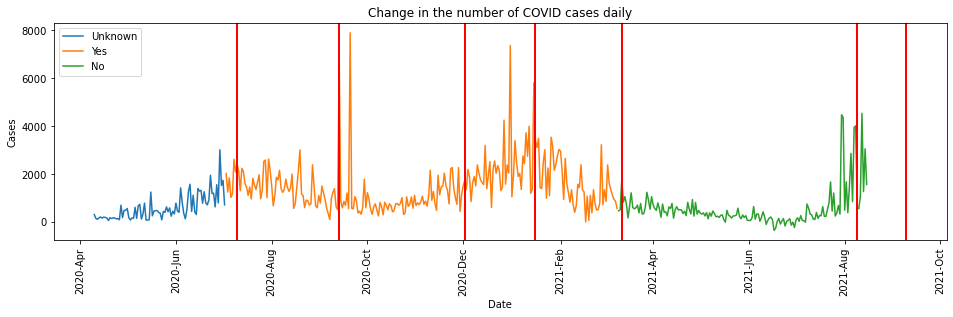

In [429]:
plot_change_points(df2,change_location2)

plt.savefig('Change in the number of COVID cases daily.jpeg')

### Change in derivative

In [436]:
algo2 = rpt.Pelt(model="rbf").fit(np.array(df2['case_rate_2']).astype('int'))
change_location2 = algo2.predict(pen=5)

In [437]:
# Point the change points:
def plot_change_points(ts,ts_change_loc):
    plt.figure(figsize=(16,4))
    sns.lineplot(data=ts, x="Date", y="case_rate_2", hue='Face_Masks_Required_in_Public')
    plt.xlabel('Date')
    plt.ylabel('Cases')
    plt.title('Second order difference of the numner of COVID cases daily')
    
    dtFmt = mdates.DateFormatter('%Y-%b')
    plt.gca().xaxis.set_major_formatter(dtFmt) 

    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))

    plt.legend()
    plt.xticks(rotation ='vertical')
    
    for x in ts_change_loc:
        plt.axvline(ts.Date.iloc[x-1],lw=2, color='red') 

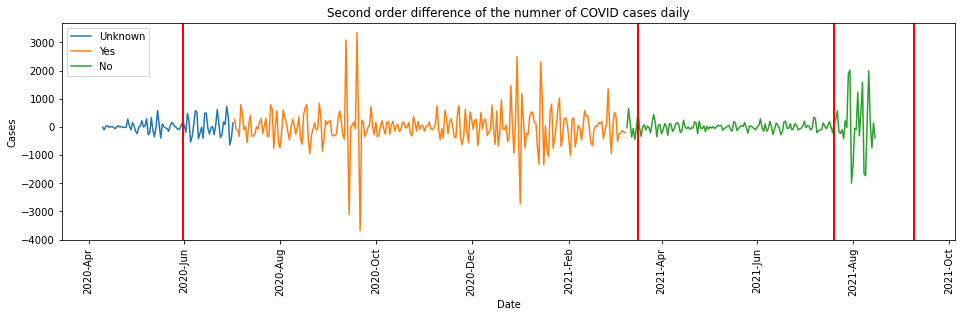

In [438]:
plot_change_points(df2,change_location2)
plt.savefig('Second order difference of the numner of COVID cases daily.jpeg')

## Summary

We can see that masking mandates were applied around july 2020 and then were lifted in March 2021 .

Though there is no specific trend that we can see here, there is a drop in cases shortly after the mask mandate was put in place. We see that there is no difference in the progression of cases with the source of mask mandate( media and official notice). When the mask mandate was lifted, there was a spike in the case rate, which is the relative change in covid cases as compared the the pervious day.
We cannot see a disctinct change point relative to the mask mandate, so we cannot confirm or reject the relationship between mask mandate in effect and the number of cases.

 